In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.6
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 11s 1s/step - loss: 0.0392
Average validation loss: 0.6085870265960693
4/4 [==============================] - 11s 1s/step - loss: 0.0392 - val_loss: 0.6086
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 16s 1s/step - loss: 0.0281 - val_loss: 0.6086
Average validation loss: 0.5247112512588501
4/4 [==============================] - 16s 1s/step - loss: 0.0281 - val_loss: 0.5666
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 21s 1s/step - loss: 0.0214 - val_loss: 0.5666
Average validation loss: 0.5404163599014282
4/4 [==============================] - 21s 1s/step - loss: 0.0214 - val_loss: 0.5579
Epoch

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 9s 1s/step - loss: 2.4196e-05
Average validation loss: 1.90856832560371e-08
8/8 [==============================] - 9s 1s/step - loss: 2.4196e-05 - val_loss: 1.9086e-08
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 19s 1s/step - loss: 2.3946e-05 - val_loss: 1.9086e-08
Average validation loss: 0.0
8/8 [==============================] - 19s 1s/step - loss: 2.3946e-05 - val_loss: 9.5428e-09
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 27s 1s/step - loss: 2.3363e-05 - val_loss: 9.5428e-09
Average validation loss: 3.7690593757133684e-08
8/8 [==============================] - 27s 1s/step - loss: 2.33

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 13s 1s/step - loss: 7.1065e-05
Average validation loss: 0.1464174809322382
12/12 [==============================] - 13s 1s/step - loss: 7.1065e-05 - val_loss: 0.1464
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 27s 1s/step - loss: 6.8490e-05 - val_loss: 0.1464
Average validation loss: 0.03354707368998788
12/12 [==============================] - 27s 1s/step - loss: 6.8490e-05 - val_loss: 0.0900
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 40s 1s/step - loss: 6.7325e-05 - val_loss: 0.0900
Average validation loss: 0.024551676974321406
12/12 [==============================] - 41s 1s/step - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 18s 1s/step - loss: 4.5390e-05
Average validation loss: 0.09007222225227451
16/16 [==============================] - 18s 1s/step - loss: 4.5390e-05 - val_loss: 0.0901
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 37s 1s/step - loss: 4.3791e-05 - val_loss: 0.0901
Average validation loss: 0.03837738325819373
16/16 [==============================] - 37s 1s/step - loss: 4.3791e-05 - val_loss: 0.0642
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 55s 1s/step - loss: 4.3952e-05 - val_loss: 0.0642
Average validation loss: 0.037599045303068124
16/16 [==============================] - 55s 1s/step -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 22s 1s/step - loss: 2.2637e-05
Average validation loss: 0.04669425049796701
20/20 [==============================] - 22s 1s/step - loss: 2.2637e-05 - val_loss: 0.0467
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 46s 1s/step - loss: 2.1809e-05 - val_loss: 0.0467
Average validation loss: 0.03901706803590059
20/20 [==============================] - 46s 1s/step - loss: 2.1809e-05 - val_loss: 0.0429
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 68s 1s/step - loss: 2.0753e-05 - val_loss: 0.0429
Average validation loss: 0.02990262070670724
20/20 [==============================] - 68s 1s/step - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 27s 1s/step - loss: 3.4999e-05
Average validation loss: 0.04746926327546438
24/24 [==============================] - 27s 1s/step - loss: 3.4999e-05 - val_loss: 0.0475
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 54s 1s/step - loss: 2.8870e-05 - val_loss: 0.0475
Average validation loss: 0.04633469134569168
24/24 [==============================] - 54s 1s/step - loss: 2.8870e-05 - val_loss: 0.0469
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 81s 1s/step - loss: 2.6481e-05 - val_loss: 0.0469
Average validation loss: 0.0706842162956794
24/24 [==============================] - 81s 1s/step - l

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 31s 771ms/step - loss: 4.8277e-05
Average validation loss: 0.03507314790040254
40/40 [==============================] - 31s 782ms/step - loss: 4.8277e-05 - val_loss: 0.0351
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 61s 758ms/step - loss: 4.2816e-05 - val_loss: 0.0351
Average validation loss: 0.17256478741765022
40/40 [==============================] - 62s 769ms/step - loss: 4.2816e-05 - val_loss: 0.1038
Epoch 3/10
40/40 [==============================] - 93s 785ms/step - loss: 4.0365e-05 - val_loss: 0.1038
Average validation loss: 0.057220638170838355
40/40 [==============================] - 94s 794ms/step - loss: 4.0365e-05 - val_loss: 0.0883
Epoch 4/10
40/40 [==============================] - 125s 796ms/step - loss: 3.6955e-05 - val_loss: 0.0883
Average validat

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 44s 921ms/step - loss: 3.1816e-05
Average validation loss: 0.04397748980287967
48/48 [==============================] - 45s 934ms/step - loss: 3.1816e-05 - val_loss: 0.0440
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 88s 906ms/step - loss: 2.2718e-05 - val_loss: 0.0440
Average validation loss: 0.02842055185404509
48/48 [==============================] - 89s 920ms/step - loss: 2.2718e-05 - val_loss: 0.0362
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 132s 907ms/step - loss: 1.8815e-05 - val_loss: 0.0362
Average validation loss: 0.019875554239964306
48/48 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 50s 893ms/step - loss: 4.8611e-05
Average validation loss: 0.044274764697677584
56/56 [==============================] - 51s 906ms/step - loss: 4.8611e-05 - val_loss: 0.0443
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 100s 880ms/step - loss: 3.2587e-05 - val_loss: 0.0443
Average validation loss: 0.024232633641596685
56/56 [==============================] - 100s 891ms/step - loss: 3.2587e-05 - val_loss: 0.0343
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 150s 884ms/step - loss: 2.5103e-05 - val_loss: 0.0343
Average validation loss: 0.026544293134585523
56/56 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 57s 892ms/step - loss: 1.9638e-05
Average validation loss: 0.025191483546223026
64/64 [==============================] - 58s 904ms/step - loss: 1.9638e-05 - val_loss: 0.0252
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 116s 906ms/step - loss: 1.3533e-05 - val_loss: 0.0252
Average validation loss: 0.024436119623715058
64/64 [==============================] - 117s 921ms/step - loss: 1.3533e-05 - val_loss: 0.0248
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 174s 903ms/step - loss: 1.0492e-05 - val_loss: 0.0248
Average validation loss: 0.015965463710017502
64/64 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 65s 901ms/step - loss: 1.8679e-05
Average validation loss: 0.05292496706048647
72/72 [==============================] - 66s 913ms/step - loss: 1.8679e-05 - val_loss: 0.0529
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 132s 916ms/step - loss: 1.3707e-05 - val_loss: 0.0529
Average validation loss: 0.02196668041869998
72/72 [==============================] - 133s 929ms/step - loss: 1.3707e-05 - val_loss: 0.0374
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 199s 918ms/step - loss: 1.0773e-05 - val_loss: 0.0374
Average validation loss: 0.021581488868428603
72/72 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 72s 907ms/step - loss: 1.7832e-05
Average validation loss: 0.02345016598701477
80/80 [==============================] - 73s 919ms/step - loss: 1.7832e-05 - val_loss: 0.0235
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 146s 903ms/step - loss: 1.1925e-05 - val_loss: 0.0235
Average validation loss: 0.02151785297319293
80/80 [==============================] - 147s 915ms/step - loss: 1.1925e-05 - val_loss: 0.0225
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 218s 897ms/step - loss: 9.3832e-06 - val_loss: 0.0225
Average validation loss: 0.02285856450907886
80/80 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 112s 1s/step - loss: 2.5953e-05
Average validation loss: 0.06702769764281886
96/96 [==============================] - 114s 1s/step - loss: 2.5953e-05 - val_loss: 0.0670
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 226s 1s/step - loss: 1.8923e-05 - val_loss: 0.0670
Average validation loss: 0.03252667186461622
96/96 [==============================] - 227s 1s/step - loss: 1.8923e-05 - val_loss: 0.0498
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 342s 1s/step - loss: 1.5507e-05 - val_loss: 0.0498
Average validation loss: 0.03762087158005064
96/96 [==============================] - 343s 1s

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 109s 908ms/step - loss: 2.2404e-05
Average validation loss: 0.06320223265852291
120/120 [==============================] - 110s 921ms/step - loss: 2.2404e-05 - val_loss: 0.0632
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 218s 893ms/step - loss: 1.5091e-05 - val_loss: 0.0632
Average validation loss: 0.019362411056257165
120/120 [==============================] - 219s 906ms/step - loss: 1.5091e-05 - val_loss: 0.0413
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 327s 897ms/step - loss: 1.3969e-05 - val_loss: 0.0413
Average validation loss: 0.12291357112820454
120/120 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 129s 896ms/step - loss: 1.2093e-05
Average validation loss: 0.027386044721222587
144/144 [==============================] - 131s 908ms/step - loss: 1.2093e-05 - val_loss: 0.0274
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 258s 887ms/step - loss: 9.4726e-06 - val_loss: 0.0274
Average validation loss: 0.02107929773370011
144/144 [==============================] - 260s 898ms/step - loss: 9.4726e-06 - val_loss: 0.0242
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 389s 895ms/step - loss: 7.6556e-06 - val_loss: 0.0242
Average validation loss: 0.017994087140929576
144/144 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 144s 901ms/step - loss: 6.3272e-06
Average validation loss: 0.016293511165713426
160/160 [==============================] - 146s 914ms/step - loss: 6.3272e-06 - val_loss: 0.0163
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 289s 894ms/step - loss: 5.0191e-06 - val_loss: 0.0163
Average validation loss: 0.013140203699003905
160/160 [==============================] - 291s 906ms/step - loss: 5.0191e-06 - val_loss: 0.0147
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 436s 903ms/step - loss: 4.0655e-06 - val_loss: 0.0147
Average validation loss: 0.04139353104380916
160/160 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 180s 900ms/step - loss: 2.5996e-05
Average validation loss: 0.018831480547087266
200/200 [==============================] - 182s 912ms/step - loss: 2.5996e-05 - val_loss: 0.0188
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 360s 886ms/step - loss: 1.8375e-05 - val_loss: 0.0188
Average validation loss: 0.018619019564648624
200/200 [==============================] - 362s 898ms/step - loss: 1.8375e-05 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 543s 903ms/step - loss: 1.3995e-05 - val_loss: 0.0187
Average validation loss: 0.015843706630545285
200/200 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:54 - loss: 5.3660e-07

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 189s 790ms/step - loss: 1.1717e-05
Average validation loss: 0.032385086688498176
240/240 [==============================] - 192s 800ms/step - loss: 1.1717e-05 - val_loss: 0.0324
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 380s 783ms/step - loss: 8.7895e-06 - val_loss: 0.0324
Average validation loss: 0.023511183979220127
240/240 [==============================] - 382s 793ms/step - loss: 8.7895e-06 - val_loss: 0.0279
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_60\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 570s 780ms/step - loss: 6.9415e-06 - val_loss: 0.0279
Average validation loss: 0.023082660077913413
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10813444541145997, 0.06227150924055346, 0.08309849565066431, 0.05485268297190487, 0.040119262183667154, 0.03322373818496999, 0.03777254245134099, 0.02669176742648233, 0.02980019905899553, 0.024180090032285762, 0.02311764587327426, 0.018305081839629426, 0.03063226145374685, 0.02339288188877085, 0.01730285484099857, 0.014839659452209846, 0.021123871010471355, 0.019081926464047307]
std_val_losses =  [0.158593135238414, 0.06260640908192476, 0.07475859732275308, 0.023073146131898155, 0.011471752748413373, 0.016812651012522436, 0.023953415955315478, 0.008127698053825296, 0.013474340400533271, 0.01566238750610212, 0.014640427055880192, 0.0086760403495667, 0.022513636628428944, 0.017910098814857504, 0.005870234701253506, 0.005094806449424704, 0.017424811502215313, 0.008394419160664494]


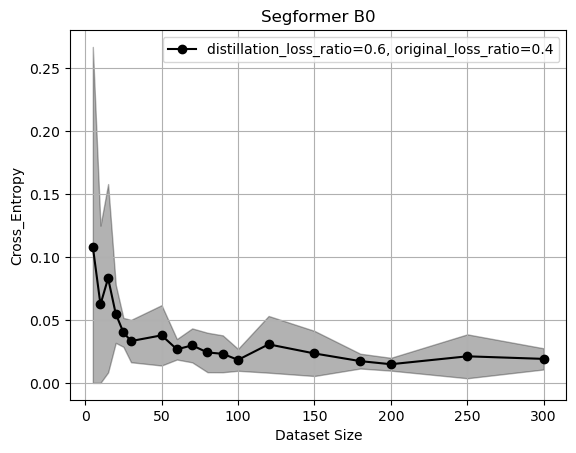

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()